## Bike Rental Dataset Data Analysis.
    Published: on May 27, 2020
    
###  Summary

    The analysis investigates data from Bike rental website to find answers on questions bellow using Python and its libraries. Data are available data for public use: https://www.lyft.com/bikes/bay-wheels/system-data. 
Analyse is divided into 2 parts:
In the first part - an exploratory data analysis on a dataset is provided.
In the second part, the main findings from the  first part were taken to  create a slide deck that leverages polished, explanatory visualizations to communicate the results. 

#### The key features in the dataset 

Each trip is anonymized and includes:
    Trip Duration (seconds)
    Start Time and Date
    End Time and Date
    Start Station ID
    Start Station Name
    Start Station Latitude
    Start Station Longitude
    End Station ID
    End Station Name
    End Station Latitude
    End Station Longitude
    Bike ID
    User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)

#### During this analysis next questions were examined:

    1 Who is the Client that rent a bike? Find client characteristics:
        - what is the average age? what's the % and number of the clients?
        - youngest and olderest client? what's the % and number of the clients?
        - male or female? what's the % and number of the clients?
        
    
    2 What is the user preferences?
        - Does a client prefer choose bike share option?
        - What rental access method is the most popular?
        - Does a client prefer to take subscription ?
 
    3. How does world lockdown influense on bike rents?

    
#### Steps to investigate questions:

    1. Wrangle data.
    
        1.1. Data gathering.
        All files were downloaded from the website 'https://s3.amazonaws.com/baywheels-data/index.html' programmatically. Files are stored in zip files, and collected from 2017 till nowdays. Data for 2017 is a one zipped file, data for 2018 (and further years) are represented grouped by each month is a separate zippe file.
        
        1.2. Assessing and Cleaning data for quaity and tidiness.

    2. Exploratory data analysis. Visualisation.
   
    3. Explanatory analysis. A slide deck that leverages polished, explanatory visualizations to communicate the results.

In [ ]:
# for map visualisation:
import pip
package_name='gmplot' 
pip.main(['install',package_name])

import pip
package_name='geopy' 
pip.main(['install',package_name])


In [3]:
# import:
import numpy as np
import os
import pandas as pd
import requests
import tweepy
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sb
import re
import datetime
import zipfile
import io
from glob import iglob
import sys
import seaborn as sb
import gmplot 
from geopy.geocoders import Nominatim

# display plots inline
%matplotlib inline


# create folder for data files ( if it is not exist ) :
folder_name = 'data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)


### 1. Wrangle data.

#### 1.1. Data gathering.

In [4]:
# main url with files to download:
url = 'https://s3.amazonaws.com/baywheels-data/index.html'

# check url:
page = requests.get(url)
print(page.status_code)

200


In [ ]:
# Output: 200 - url is ok

In [ ]:
# Download data from url:

# function to create folder for each year ( if it is not exist )
def folder_name_func(year):
    folder_name_y = folder_name + '/' + year
    if not os.path.exists(folder_name_y):
        os.makedirs(folder_name_y)
    return folder_name_y
        
# Function:
def get_files_func(data_name, file_url_num, file_url = 'def'):
    # if parameter 'file_url' of function is skipped then 'file_url =': 
    if file_url == 'def':
        file_url = 'https://s3.amazonaws.com/'+ data_name +'-data/'+ file_url_num + '-' + data_name + '-tripdata.csv.zip'
    # check if url exists:  
    r = requests.get(file_url, stream=True)
    url_exists = r.status_code # = 200 - url exists
    if url_exists == 200: 
        check = zipfile.is_zipfile(io.BytesIO(r.content))
        if (check):
            z = zipfile.ZipFile(io.BytesIO(r.content))
            z.extractall(folder_name_y)
        # if not zip format try scv format
        else:
            try:
                download = requests.get(ur,stream=True)
                # take file name from the url:
                tmp = file_url.split('/'[-1])
                f_name = tmp[len(tmp) - 1]
                # download file:
                with open(folder_name_y +'/'+ f_name, 'w') as file:
                    file.write(download.text)
            except:
                print(file_url + "file wasn't downloaded")
    return url_exists

# start from 201801, then 201802,...until today minus one or few months
now = datetime.datetime.now()
start_year = 2018
files_in_year = np.arange(1,13) 
year_count = now.year - start_year + 1

# get file for not standart url for 2017 year:
urls = ['https://s3.amazonaws.com/baywheels-data/2017-fordgobike-tripdata.csv.zip']
folders=[]
folder_name_y = folder_name_func('2017')
folders.append(folder_name_y)
get_files_func('fordgobike','2017',urls[0])

# get files for other years:
for i in range(year_count):
    year = str(int(start_year) + i)

    for fy in files_in_year:
        fy = str(fy)       
        if len(fy) == 1:
            file_url_num = year + "0" + fy
        else:
            file_url_num = year + fy
        folder_name_y = folder_name_func(year)
        if folder_name_y not in folders:
            folders.append(folder_name_y)
        func_resp = get_files_func('fordgobike', file_url_num)
        if func_resp != 200:
            get_files_func('baywheels', file_url_num)
    

In [10]:
# read all *.scv files from the 'folders' to dataframe 'df':
dirpath = os.getcwd()
df = pd.DataFrame()
for i in range(len(folders)):
    path = os.getcwd() + '/' + folders[i] + '/*.csv'
    # to dataframe:
    df2 = pd.concat((pd.read_csv(f, dtype='unicode', index_col=False, low_memory=False) 
                     for f in iglob(path, recursive=True)), ignore_index=True, sort=False)   
    df = df.append(df2)

#### 1.2. Assessing and Cleaning data for quaity and tidiness.

In [11]:
df.head(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,rental_access_method,ride_id,rideable_type,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,member_casual
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74,Laguna St at Hayes St,37.7764348192,-122.4262440205,43,San Francisco Public Library (Grove St at Hyde...,37.7787677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284,Yerba Buena Center for the Arts (Howard St at ...,37.7848720844,-122.4008756876,96,Dolores St at 15th St,37.7662102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245,Downtown Berkeley BART,37.8703477,-122.2677637,245,Downtown Berkeley BART,37.8703477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60,8th St at Ringold St,37.7745204011,-122.4094493687,5,Powell St BART Station (Market St at 5th St),37.7838993571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239,Bancroft Way at Telegraph Ave,37.8688126,-122.258764,247,Fulton St at Bancroft Way,37.8677892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# check data:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5879670 entries, 0 to 989265
Data columns (total 26 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   duration_sec             object
 1   start_time               object
 2   end_time                 object
 3   start_station_id         object
 4   start_station_name       object
 5   start_station_latitude   object
 6   start_station_longitude  object
 7   end_station_id           object
 8   end_station_name         object
 9   end_station_latitude     object
 10  end_station_longitude    object
 11  bike_id                  object
 12  user_type                object
 13  member_birth_year        object
 14  member_gender            object
 15  bike_share_for_all_trip  object
 16  rental_access_method     object
 17  ride_id                  object
 18  rideable_type            object
 19  started_at               object
 20  ended_at                 object
 21  start_lat                object


- Output: 5 879 670 rows, 26 columns.
    * Data types - change.

In [13]:
df[df.duplicated()]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,rental_access_method,ride_id,rideable_type,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,member_casual
875085,184,2020-03-01 15:59:07,2020-03-01 16:02:12,NaN,NaN,37.2910223333,-121.8491438333,NaN,NaN,37.2944546667,...,clipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875090,167,2020-03-01 21:03:10,2020-03-01 21:05:58,NaN,NaN,37.2911448333,-121.849215,NaN,NaN,37.2944523333,...,clipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875113,515,2020-03-01 16:18:04,2020-03-01 16:26:40,NaN,NaN,37.2932331667,-121.881765,NaN,NaN,37.3057328333,...,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875124,222,2020-03-01 12:51:13,2020-03-01 12:54:56,NaN,NaN,37.2936736667,-121.8519005,NaN,NaN,37.291026,...,clipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875158,197,2020-03-01 16:46:45,2020-03-01 16:50:03,NaN,NaN,37.2944796667,-121.8524443333,NaN,NaN,37.2911455,...,clipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989232,2101,2020-03-01 15:34:57,2020-03-01 16:09:59,NaN,NaN,37.8090655,-122.4748503333,NaN,NaN,37.80521,...,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
989233,2205,2020-03-01 15:36:34,2020-03-01 16:13:19,NaN,NaN,37.8090743333,-122.4749183333,NaN,NaN,37.8051858333,...,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
989234,2035,2020-03-01 15:36:28,2020-03-01 16:10:23,NaN,NaN,37.8091003333,-122.474939,NaN,NaN,37.8051731667,...,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
989237,1183,2020-03-01 12:26:56,2020-03-01 12:46:40,NaN,NaN,37.8091378333,-122.415689,NaN,NaN,37.8061951667,...,app,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


   * Duplicates ( 7512 rows )- remove.

In [14]:
df.query('start_time == "2020-03-01 15:59:07"')

NumExpr defaulting to 4 threads.


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,rental_access_method,ride_id,rideable_type,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,member_casual
410407,184,2020-03-01 15:59:07,2020-03-01 16:02:12,NaN,NaN,37.2910223333,-121.8491438333,NaN,NaN,37.2944546667,...,clipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
557650,610,2020-03-01 15:59:07,2020-03-01 16:09:17,NaN,NaN,37.7755925,-122.3927888333,43,San Francisco Public Library (Grove St at Hyde...,37.7787677,...,clipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875085,184,2020-03-01 15:59:07,2020-03-01 16:02:12,NaN,NaN,37.2910223333,-121.8491438333,NaN,NaN,37.2944546667,...,clipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
935068,610,2020-03-01 15:59:07,2020-03-01 16:09:17,NaN,NaN,37.7755925,-122.3927888333,43,San Francisco Public Library (Grove St at Hyde...,37.7787677,...,clipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  * Check if there is a row with end_station_name is null/NaN and its end_station_latitude & end_station_longitude are equal to end_station_latitude & end_station_longitude of another row with end_station_name that is not Null/NaN  - then end_station_name of first row make equal to the second one.

In [15]:
# check empty rows in as a % of all data:
100 * df.isnull().sum() / len(df)

duration_sec                1.433057
start_time                  1.433057
end_time                    1.433057
start_station_id           10.368473
start_station_name         10.337281
start_station_latitude      1.433057
start_station_longitude     1.433057
end_station_id             10.423306
end_station_name           10.392250
end_station_latitude        1.433057
end_station_longitude       1.433057
bike_id                     1.433057
user_type                   1.433057
member_birth_year          56.068963
member_gender              56.062942
bike_share_for_all_trip    29.801417
rental_access_method       87.436438
ride_id                    98.566943
rideable_type              98.566943
started_at                 98.566943
ended_at                   98.566943
start_lat                  98.566943
start_lng                  98.566943
end_lat                    98.569358
end_lng                    98.569358
member_casual              98.566943
dtype: float64

- Output: member_birth_year, member_gender, bike_share_for_all_trip, rental_access_method, rideable_type, member_casual - % of missing value is extremely high for data analyses.
    * Check these columns for each year separately.

In [16]:
# copy df:
df2 = df.copy()

In [17]:
# remove duplicates:
df2.drop_duplicates(inplace = True)

In [50]:
# change data types:

# object to datetime and create new columns:

df2['start_time']  = pd.to_datetime(df2['start_time'])

df2['start_year']  = df2['start_time'].dt.year
df2['start_month']  = df2['start_time'].dt.month
df2['start_day']  = df2['start_time'].dt.day
df2['start_weekday'] = df2['start_time'].dt.weekday
df2['start_hour'] = df2['start_time'].dt.hour

df2['end_time']  = pd.to_datetime(df2['end_time'])

In [19]:
# object to float:     
df2['start_station_latitude']  = pd.to_numeric(df2['start_station_latitude'], errors='coerce', downcast='float')
df2['start_station_longitude']  = pd.to_numeric(df2['start_station_longitude'], errors='coerce', downcast='float')

df2['end_station_latitude']  = pd.to_numeric(df2['end_station_latitude'], errors='coerce', downcast='float')
df2['end_station_longitude']  = pd.to_numeric(df2['end_station_longitude'], errors='coerce', downcast='float')

In [20]:
# replace Nan -> '' for string data
df2.fillna({'member_gender':'','bike_share_for_all_trip':'','rental_access_method':''}, inplace=True)

In [21]:
# replace Nan -> 0 for numeric data
df2.fillna({'start_station_id':0,'end_station_id':0, 'member_birth_year':0}, inplace=True)

In [37]:
# object to int:
df2['bike_id']  = pd.to_numeric(df2['bike_id'], errors='coerce', downcast='integer')
df2['start_station_id']  = pd.to_numeric(df2['start_station_id'], errors='coerce', downcast='integer')
df2['end_station_id']  = pd.to_numeric(df2['end_station_id'], errors='coerce', downcast='integer')
df2['member_birth_year']  = pd.to_numeric(df2['member_birth_year'], errors='coerce', downcast='integer')
df2['duration_sec']  = pd.to_numeric(df2['duration_sec'], errors='coerce', downcast='integer')

df2['duration_min'] = round(df2['duration_sec']/60)
df2['duration_min']  = pd.to_numeric(df2['duration_min'], errors='coerce', downcast='integer')


In [32]:
# drop columns:
df2.drop(['duration_sec','start_time','started_at','ended_at', 'start_lat','start_lng','end_lat','end_lng','rideable_type','ride_id','member_casual'], axis = 1, inplace = True)

In [48]:
df2.dtypes

end_time                   datetime64[ns]
start_station_id                    int16
start_station_name                 object
start_station_latitude            float32
start_station_longitude           float32
end_station_id                      int16
end_station_name                   object
end_station_latitude              float32
end_station_longitude             float32
bike_id                           float64
user_type                          object
member_birth_year                   int16
member_gender                      object
bike_share_for_all_trip            object
rental_access_method               object
start_year                        float64
start_month                       float64
start_day                         float64
start_weekday                     float64
start_hour                        float64
duration_min                      float64
dtype: object

In [49]:
df2.sample(5)

,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,...,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method,start_year,start_month,start_day,start_weekday,start_hour,duration_min
350935,2020-02-17 13:58:08.996,278,The Alameda at Bush St,37.331932,-121.904892,402,Raymond Bernal Jr Memorial Park (8th St at Hed...,37.356834,-121.895935,12009.0,...,0,,,,2020.0,2.0,17.0,0.0,13.0,19.0
210277,2017-10-24 11:14:48.394,146,30th St at San Jose Ave,37.742313,-122.423180,138,Jersey St at Church St,37.750900,-122.427414,2138.0,...,0,,,,2017.0,10.0,24.0,1.0,11.0,7.0
2201343,2019-11-18 13:32:04.682,58,Market St at 10th St,37.776619,-122.417381,6,The Embarcadero at Sansome St,37.804771,-122.403236,2561.0,...,0,,No,,2019.0,11.0,18.0,0.0,13.0,21.0
2266841,2019-11-08 14:21:09.210,460,Terry Francois Blvd at Warriors Way,37.769096,-122.386330,3,Powell St BART Station (Market St at 4th St),37.786377,-122.404907,9951.0,...,0,,No,,2019.0,11.0,8.0,4.0,14.0,16.0
642274,2020-02-16 14:05:24.000,369,Hyde St at Post St,37.787350,-122.416649,0,NaN,37.784477,-122.404305,483212.0,...,0,,,app,2020.0,2.0,16.0,6.0,13.0,14.0


In [51]:
# check columns that have high % of missing data separetaly by years.
# member_birth_year, member_gender, rental_access_method

# 1.member_birth_year:
100 * df2.query('member_birth_year == 0').start_year.value_counts()/df2.start_year.value_counts()


2017.0    100.000000
2018.0      5.940696
2019.0     66.892596
2020.0    100.000000
Name: start_year, dtype: float64

- Output: for member age analyse we can take only 2018 year with 5.9% of missing value of member_birth_year data.

In [52]:
# create dataframe for member age analyse:
df_memb_age = df2.query('start_year == 2018 & member_birth_year != 0')
df_memb_age['member_age']  = int(datetime.datetime.now().year) - df_memb_age['member_birth_year']
df_memb_age.member_age.value_counts()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


32     102836
33      86554
31      84830
30      81999
35      79126
        ...  
111         4
131         3
114         2
117         1
90          1
Name: member_age, Length: 86, dtype: int64

In [53]:
print("Data actual for 2018 year:")
print("The average age of member that rent a bike is ", df_memb_age.member_age.mean())
print("Oldest members ",df_memb_age.member_age.max()," and ",df_memb_age.query('member_age!= member_age.max()').member_age.max(), "years old.")
print("Youngest members ",df_memb_age.member_age.min()," and ",df_memb_age.query('member_age!= member_age.min()').member_age.min(), "years old.")

Data actual for 2018 year:
The average age of member that rent a bike is  36.91203780027758
Oldest members  139  and  132 years old.
Youngest members  20  and  21 years old.


In [54]:
df_memb_age.query('member_age in (139, 132, 20, 21)').member_age.value_counts()

21     13348
20      5390
132       23
139        5
Name: member_age, dtype: int64

- Output: 
    youngest members at age 20 made 13 348 rides in 2018;
    youngest members at age 21 made 5 390 rides in 2018;
    oldest members at age 132 made 23 rides in 2018;
    oldest members at age 139 made 5 rides in 2018.

In [55]:
# 2.member_gender:
100 * df2.query('member_gender == ""').start_year.value_counts()/df2.start_year.value_counts()

2017.0    100.000000
2018.0      5.921863
2019.0     66.892476
2020.0    100.000000
Name: start_year, dtype: float64

- Output: results similar to previous where member age was explored. 
  For member gender analysis we can take only 2018 year with 5.9% of missing value of member gender data.

In [56]:
# create dataframe for member gender analyse:
df_memb_gender = df2.query('start_year == 2018 & member_gender != ""')

# check popuar gender:
100 * df_memb_gender.member_gender.value_counts()/df_memb_gender.shape[0]


Male      73.464058
Female    24.991416
Other      1.544526
Name: member_gender, dtype: float64

- Output: Male more often rented a bike in 2018.

In [57]:
# 3.rental_access_method:
100 * df2.query('rental_access_method == ""').start_year.value_counts()/df2.start_year.value_counts()

2017.0    100.000000
2018.0    100.000000
2019.0     95.179943
2020.0     31.994496
Name: start_year, dtype: float64

- Output: for rental_access_method analyse we can't take any data - min % of missing data is 32%.

In [58]:
# 3.bike_share_for_all_trip:
100 * df2.query('bike_share_for_all_trip == ""').start_year.value_counts()/df2.start_year.value_counts()

2017.0    100.000000
2018.0           NaN
2019.0      9.703257
2020.0    100.000000
Name: start_year, dtype: float64

- Output: for bike_share_for_all_trip analyse we can take only 2019 year with 9.7 % of missing value of bike_share_for_all_trip data.

In [59]:
# create dataframe for bike_share_for_all_trip analyse:
df_bike_share = df2.query('start_year == 2019 & bike_share_for_all_trip != ""')

# check %:
100 * df_bike_share.bike_share_for_all_trip.value_counts()/df_bike_share.shape[0]

No     92.155758
Yes     7.844242
Name: bike_share_for_all_trip, dtype: float64

- Output: only 8% of people used options 'Bike Share For All Trip' in 2019.

In [60]:
print('Number of rides by user types:',"\n", df2.user_type.value_counts() ,"\n")

print('Percentage of rides by user types:',"\n", 100 * df2.user_type.value_counts()/df2.shape[0])

Number of rides by user types: 
 Subscriber    4552602
Customer      1235297
Name: user_type, dtype: int64 

Percentage of rides by user types: 
 Subscriber    77.528602
Customer      21.036508
Name: user_type, dtype: float64


In [61]:
# Add a new column 'user_type_int' with 1 and 0 values (1 - user_type = Subscriber, 0 - user_type = Customer):
df2['user_type_int'] = 1
df2.loc[df2['user_type'] == "Customer", 'user_type_int'] = 0

### 2. Exploratory data analysis. Visualisation.

Text(0.5, 0, 'Member age')

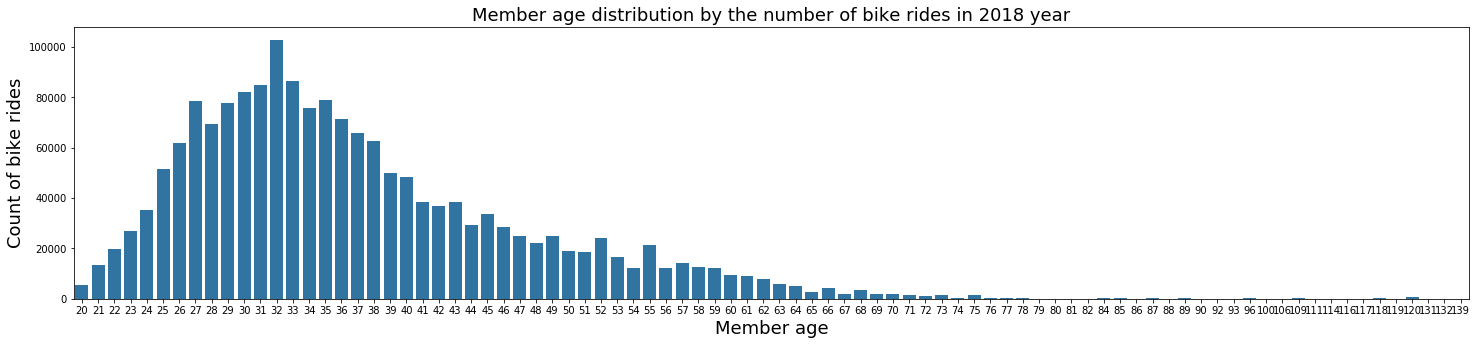

In [62]:
# Member age in 2018 :
plt.figure(figsize=(25,5))
base_color = sb.color_palette()[0]
sb.countplot(data = df_memb_age, x = 'member_age', color = base_color)
plt.title('Member age distribution by the number of bike rides in 2018 year', fontsize=18)
plt.ylabel('Count of bike rides', fontsize=18)
plt.xlabel('Member age', fontsize=18)

 - Output: number of bike rides were made by people at 27 - 35 years old.

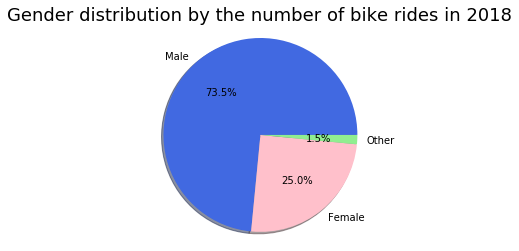

In [63]:
# Member gender in 2018 :
source_labels = df_memb_gender.member_gender.value_counts().index
source_counts = df_memb_gender.member_gender.value_counts()
colors = ['royalblue','pink',  'lightgreen']

plt.pie(source_counts, labels = source_labels, autopct='%1.1f%%', shadow=True, colors=colors)

plt.title('Gender distribution by the number of bike rides in 2018', fontsize=18)
plt.axis('equal')
plt.show();


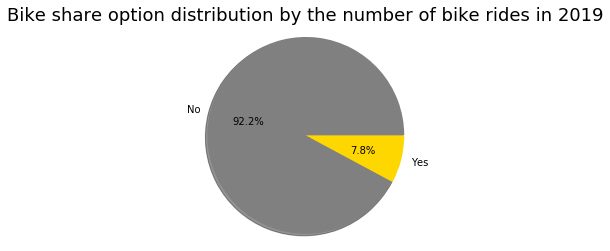

In [64]:
# bike_share_for_all_trip in 2019 :
source_labels = df_bike_share.bike_share_for_all_trip.value_counts().index
source_counts = df_bike_share.bike_share_for_all_trip.value_counts()
colors = ['grey','gold']

plt.pie(source_counts, labels = source_labels, autopct='%1.1f%%', shadow=True, colors=colors)

plt.title('Bike share option distribution by the number of bike rides in 2019', fontsize=18)
plt.axis('equal')
plt.show();

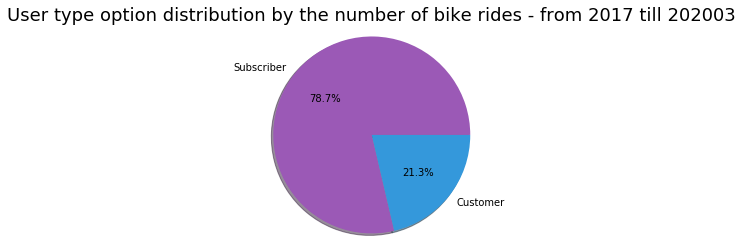

In [65]:
# user_type  :
source_labels = df2.user_type.value_counts().index
source_counts = df2.user_type.value_counts()
colors = ["#9b59b6", "#3498db"]

plt.pie(source_counts, labels = source_labels, autopct='%1.1f%%', shadow=True, colors=colors)

plt.title('User type option distribution by the number of bike rides - from 2017 till 202003', fontsize=18)
plt.axis('equal')
plt.show();


Text(0.5, 0, 'Years')

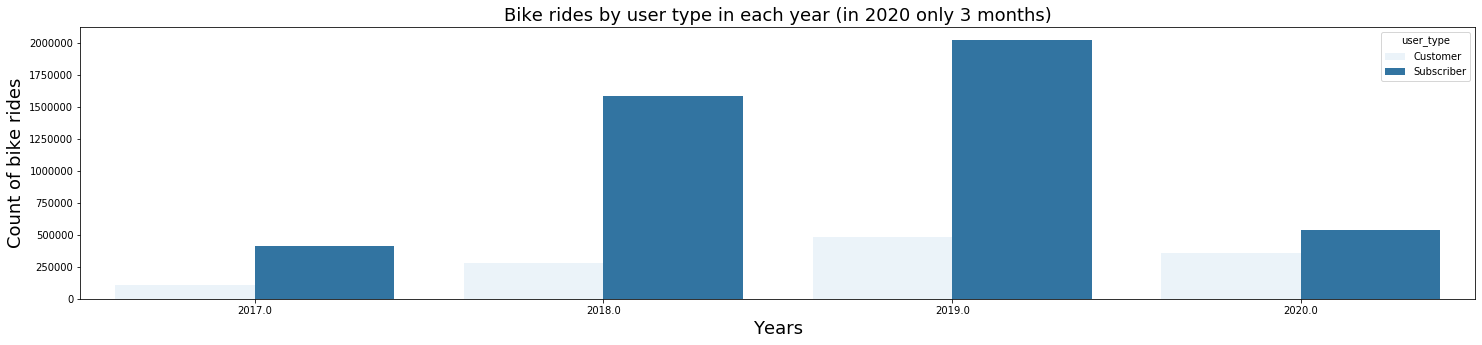

In [66]:
# User type by years :
plt.figure(figsize=(25,5))
base_color = sb.color_palette()[0]

ct_counts = df2.groupby(['start_year','user_type']).size()
ct_counts = ct_counts.reset_index(name='count')

ct_counts.pivot(index='start_year',columns='user_type',values='count')

sb.countplot(data = df2, x = 'start_year', hue='user_type', color = base_color)

plt.title('Bike rides by user type in each year (in 2020 only 3 months)', fontsize=18)
plt.ylabel('Count of bike rides', fontsize=18)
plt.xlabel('Years', fontsize=18)

In [ ]:
- Output: for  2020 - data were taken only for 3 months.
    People prefer rent a bike through subscription.

Text(0.5, 0, 'Month')

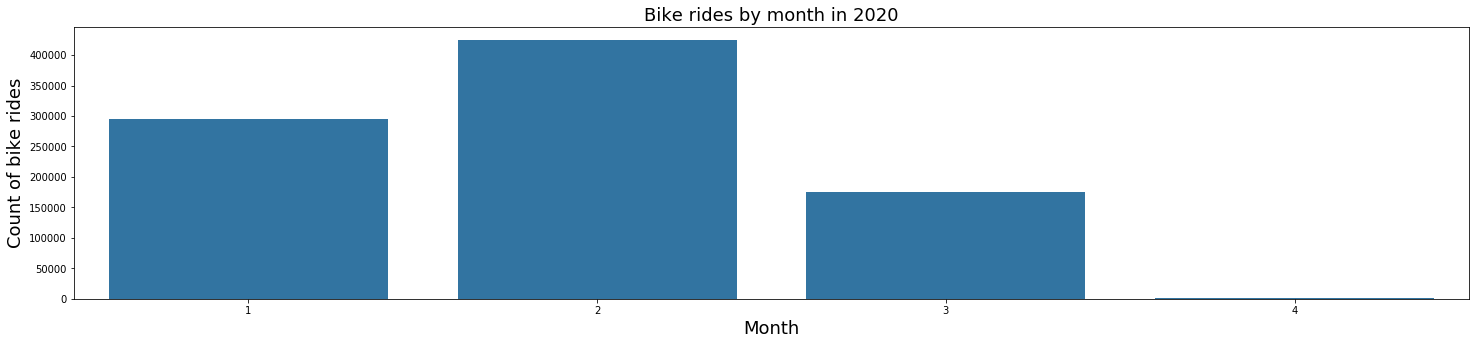

In [592]:
# 2020 - detaily March, April - wrold lockdown :
plt.figure(figsize=(25,5))
base_color = sb.color_palette()[0]
sb.countplot(data = df2.query("start_year == 2020"), x = 'start_month', color = base_color)

plt.title('Bike rides by month in 2020', fontsize=18)
plt.ylabel('Count of bike rides', fontsize=18)
plt.xlabel('Month', fontsize=18)

Text(0.5, 0, 'Month')

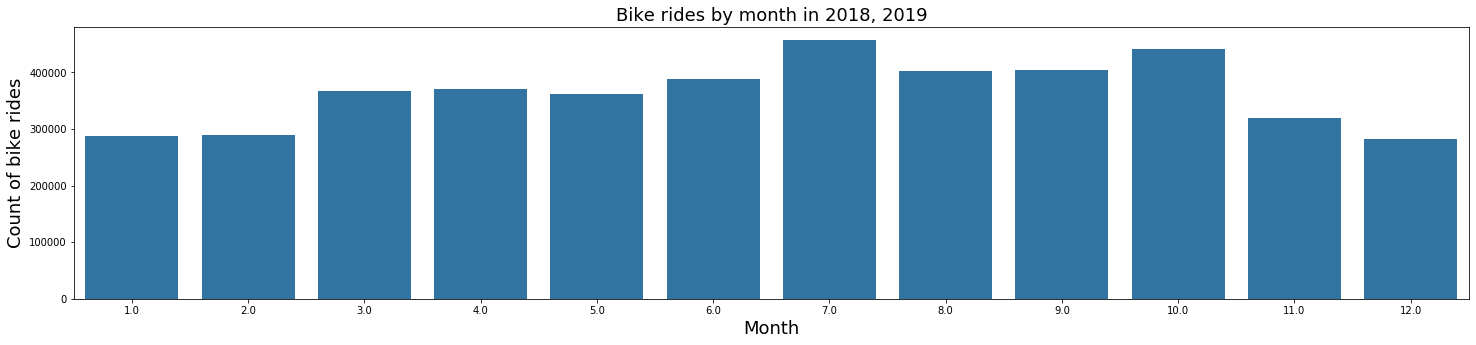

In [67]:
# 2019,2018 - by month :
plt.figure(figsize=(25,5))
base_color = sb.color_palette()[0]
sb.countplot(data = df2.query("start_year in (2018, 2019)"), x = 'start_month', color = base_color)

plt.title('Bike rides by month in 2018, 2019', fontsize=18)
plt.ylabel('Count of bike rides', fontsize=18)
plt.xlabel('Month', fontsize=18)

- Output: The number of bike rents decreased rapidly  in March of 2020 more than in two times  compared with February data, it happened due to world lockdown (covid-19). On the other hand, we see that there is a tendency of increasing number of bike rents in March in previous two year.
- There is also a tendency of decreasing number of bike rentals in winter months. The peak of bike rentals comes to June.

Text(0.5, 0, 'Weekdays')

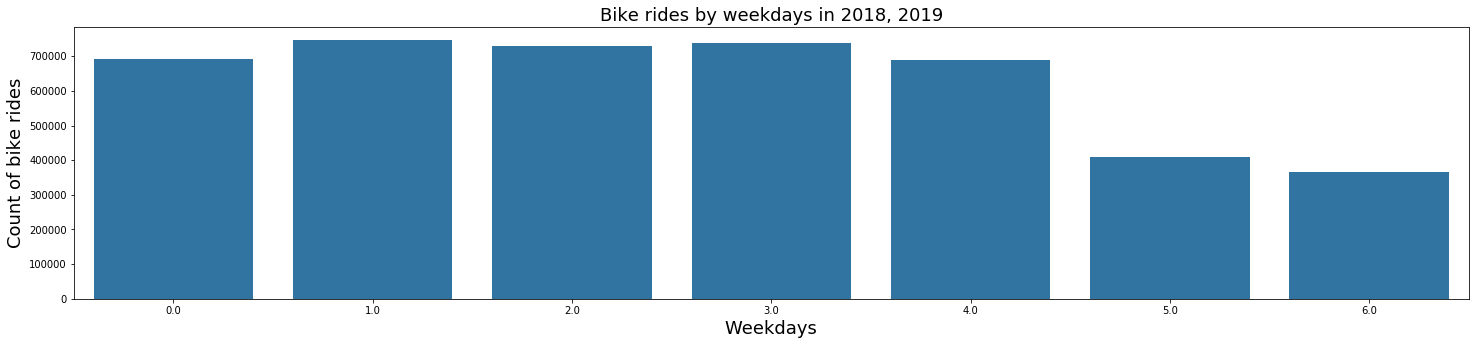

In [68]:
# 2019,2018 - by weekdays :
plt.figure(figsize=(25,5))
base_color = sb.color_palette()[0]
sb.countplot(data = df2.query("start_year in (2018, 2019)"), x = 'start_weekday', color = base_color)

plt.title('Bike rides by weekdays in 2018, 2019', fontsize=18)
plt.ylabel('Count of bike rides', fontsize=18)
plt.xlabel('Weekdays', fontsize=18)

- Output: Number of bike rides is lower almost in two times on weekends.

Text(0.5, 0, 'Hours')

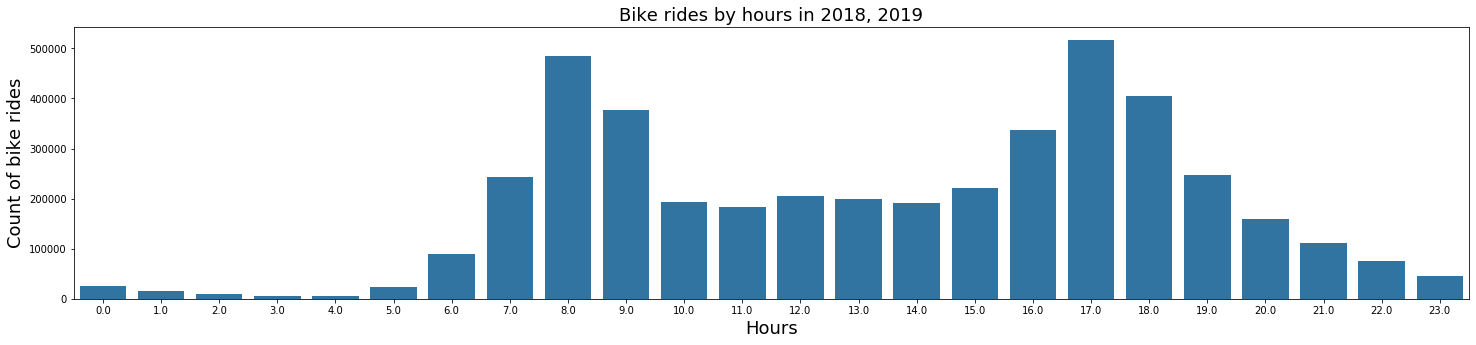

In [69]:
# 2019,2018 - by hours :
plt.figure(figsize=(25,5))
base_color = sb.color_palette()[0]
sb.countplot(data = df2.query("start_year in (2018, 2019)"), x = 'start_hour', color = base_color)

plt.title('Bike rides by hours in 2018, 2019', fontsize=18)
plt.ylabel('Count of bike rides', fontsize=18)
plt.xlabel('Hours', fontsize=18)

- Output: The peak of bike rentals comes between 7 a.m. and 9 a.m. and between 16 p.m. and 18 p.m. 

In [71]:
# function to determin city:
geolocator = Nominatim(user_agent="geoapiExercises")

def city_state_country(coord):
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    city = address.get('city', '')
    #state = address.get('state', '')
    #country = address.get('country', '')
    return city #, state, country

In [76]:
df2_2020 = df2.query('start_year == 2020 & start_station_latitude != 0.0 & start_station_longitude != 0.0')

In [ ]:
# create a new column - city:

df2_2020['city'] = ""

for i in range(len(df2_2020) - 1):
    coord = str(df2_2020['start_station_latitude'].iloc[i]) +","+str(df2_2020['start_station_longitude'].iloc[i])
    try:
        df2_2020['city'].iloc[i] = city_state_country(coord)
    except:
        print(coord)

In [766]:
#city_state_country(df2['coord'].iloc[1])[0]
df2.head(5)

,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,...,rental_access_method,start_year,start_month,start_day,start_weekday,start_hour,duration_min,user_type_int,city,state
0,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776436,-122.426247,43,San Francisco Public Library (Grove St at Hyde...,37.778767,-122.415932,96,...,,2017,12,31,6,16,1335,0,San Francisco,
1,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784874,-122.400879,96,Dolores St at 15th St,37.766209,-122.426613,88,...,,2017,12,31,6,15,1313,0,San Francisco,
2,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870346,-122.267761,245,Downtown Berkeley BART,37.870346,-122.267761,1094,...,,2017,12,31,6,22,763,0,Berkeley,
3,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774521,-122.409447,5,Powell St BART Station (Market St at 5th St),37.783901,-122.408447,2831,...,,2017,12,31,6,17,1036,0,San Francisco,
4,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258766,247,Fulton St at Bancroft Way,37.867790,-122.265900,3167,...,,2017,12,31,6,14,727,1,Berkeley,


Text(0.5, 0, 'User type')

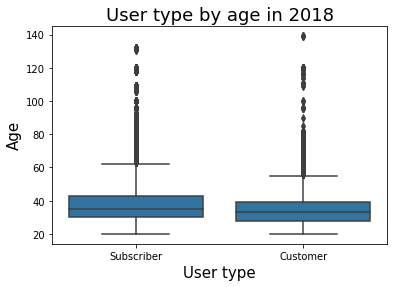

In [673]:
# user_type vs member_age:
sb.boxplot(data = df_memb_age, x = 'user_type', y = 'member_age', color = base_color)
plt.title('User type vs age in 2018', fontsize=18)
plt.ylabel('Age', fontsize=15)
plt.xlabel('User type', fontsize=15)

Text(0.5, 0, 'User gender')

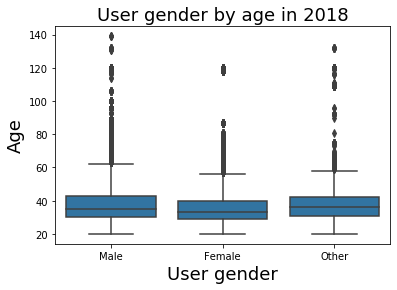

In [674]:
# user_type vs member_gender:
sb.boxplot(data = df_memb_age, x = 'member_gender', y = 'member_age', color = base_color)
plt.title('User gender vs age in 2018', fontsize=18)
plt.ylabel('Age', fontsize=18)
plt.xlabel('User gender', fontsize=18)

Text(0.5, 1.0, 'Member age vs duration (min) in 2018')

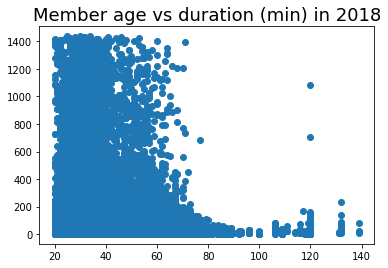

In [697]:
plt.scatter(data = df_memb_age, x = 'member_age', y = 'duration_min', color = base_color)
plt.title('Member age vs duration (min) in 2018', fontsize=18)

### Conclusion

Dataset  -  5 879 670 rows, 26 columns.

1. Client characteristics:

        The average age of member that rent a bike is 37 years old.
        Oldest members  139  and  132 years old.
        Youngest members  20  and  21 years old.

        Youngest members at age 20 made 13 348 rides in 2018; 
        Youngest members at age 21 made 5 390 rides in 2018; 
        Oldest members at age 132 made 23 rides in 2018; 
        Oldest members at age 139 made 5 rides in 2018.

        The most number of bike rides were made by people at 27 - 35 years old.

        Male (73%) more often rented a bike in 2018.

2. User preferences: 

        Only 8% of people used options 'Bike Share For All Trip'.
        People prefer rent a bike through subscription.

        Number of rides by user types: 
          Subscriber - 4 552 602 (78%)
          Customer   - 1 235 297 (22%)     

        There is also a tendency of decreasing number of bike rentals in winter months and increasing in spring time. The peak of bike rentals comes to June.
        Number of bike rides is lower almost in two times on weekends.
        The peak of bike rentals comes between 7 a.m. and 9 a.m. and between 16 p.m. and 18 p.m. 

3. The number of bike rents decreased rapidly in March of 2020 more than in two times compared with February data, it happened due to world lockdown (covid-19). 


Data limitation: 
    Data were taken for 2017, 2018, 2019, 2020 years. For 2017 and 2020 data are not full.
    Data analysis on clients age and gender was made only for 2018 year.
    Data analysis on bike share option was made only for 2019 year.